In [6]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
from mprompt.modules.emb_diff_module import EmbDiffModule
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
import notebook_helper
import mprompt.viz
import scipy.special
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import pandas as pd
import joblib
# from mprompt.config import RESULTS_DIR
import torch.cuda
import json
from sklearn.linear_model import RidgeCV
import pandas as pd
import re
import pyLDAvis
import pyLDAvis.lda_model
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
RESULTS_DIR = join('/home/chansingh/mprompt/results')
expls_scores_bert = joblib.load(join(RESULTS_DIR, 'bert', 'wiki_norm_std', 'wiki_our_syn_perc_std_score.pkl'))

In [10]:
df_f = pd.read_pickle(join(RESULTS_DIR, 'results_fmri.pkl'))
expls_fmri = df_f['top_explanation_init_strs'].values.tolist()
df_fmri = pd.DataFrame.from_dict({
    'layer': 'fmri',
    'score': df_f['top_score_synthetic'].values,
    'expl': expls_fmri,
    'roi_func': df_f['roi_func'].values,
})

In [11]:
# make each roi into one-hot column
unique_rois = sorted(
    set(
        sum(
            [
                [None if x == "--" else x for x in roi_func]
                for roi_func in df_f["roi_func"].values
            ],
            [],
        )
    )
)
unique_rois.remove("-")
for k in unique_rois:
    df_fmri[f"roi___{k}"] = df_f["roi_func"].apply(lambda x: k in x)
cols_fmri_top = (
    df_fmri[[k for k in df_fmri.columns if k.startswith("roi___")]]
    .sum()
    .sort_values(ascending=False)
    .index[:6]
)
layer_rep = []
scores_fmri_top = []
for col in cols_fmri_top:
    d = df_fmri[df_fmri[col]]
    # print(d.shape)
    layer_rep += [col.replace('roi___', '')] * d.shape[0]
    scores_fmri_top += d['score'].values.tolist()

# Make boxplots

<>:57: DeprecationWarning: invalid escape sequence '\s'
<>:57: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_3265947/3253639741.py:57: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel("Explanation score ($\sigma_f$)")


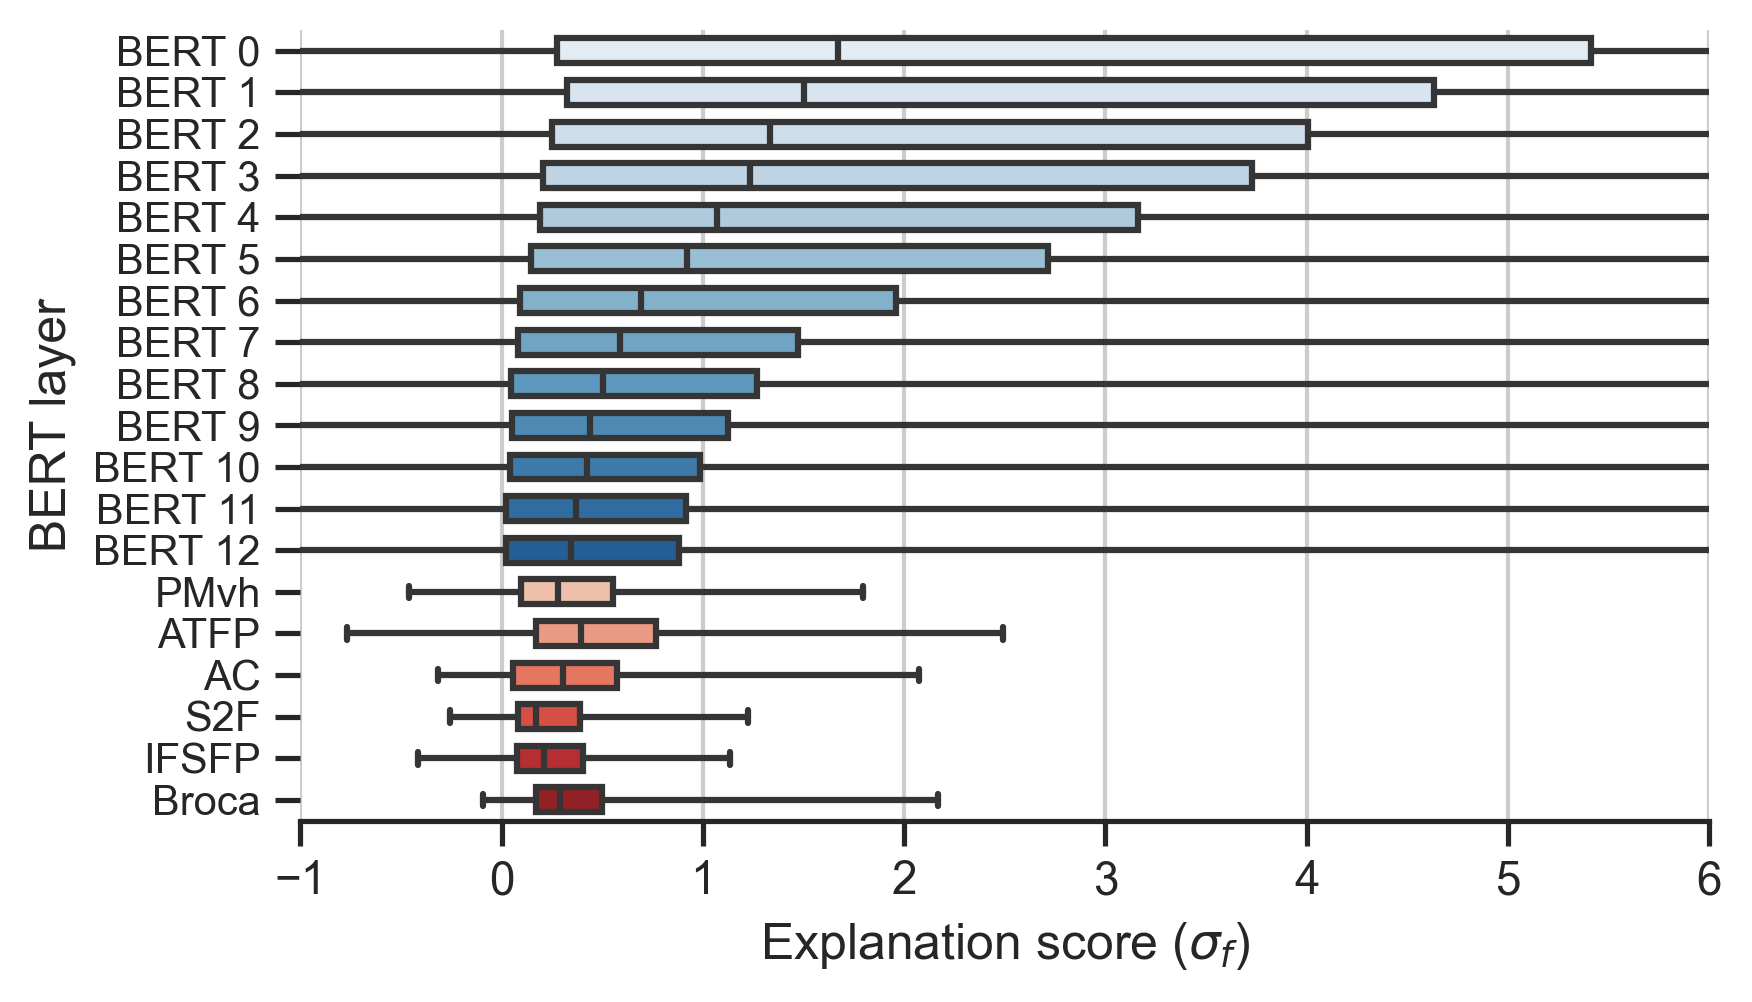

In [12]:
# set up df
sns.set_theme(style="ticks")
layer = sum(
    [
        [f"BERT {i}"] * expls_scores_bert.shape[1]
        for i in range(expls_scores_bert.shape[0])
    ],
    [],
)
df_bert_plot = pd.DataFrame.from_dict(
    {
        "layer": layer,
        "score": expls_scores_bert.flatten(),
    }
)
df_fmri_plot = pd.DataFrame.from_dict(
    {
        "layer": layer_rep,
        "score": np.array(scores_fmri_top)
        * 10,  # note: need to fix this normalization scalar
    }
)

df = pd.concat([df_bert_plot, df_fmri_plot]).reset_index()

# # make plot
lay = df["layer"].unique()
n1 = len(df_bert_plot['layer'].unique())
n2 = len(df_fmri_plot['layer'].unique())
hues = sns.color_palette("Blues", int(1.3 * n1))[1:][:n1] \
    + sns.color_palette("Reds", int(1.3 * n2))[1:][:n2]
palette = dict(zip(lay, hues))

f, ax = plt.subplots(figsize=(6, 3.5), dpi=300)
sns.boxplot(
    x="score",
    y="layer",
    data=df,
    width=0.6,
    whis=[0, 100],
    # palette="vlag",
    hue="layer",
    palette=palette,
    dodge=False,
)
plt.legend([], [], frameon=False)
# , whis=0, fliersize=0)
plt.xlim(-1, 6)

# Add in points to show each observation
# sns.stripplot(x="score", y="layer", data=df,
#   size=1.3, color=".5", linewidth=0, alpha=0.1, legend=False)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.xlabel("Explanation score ($\sigma_f$)")
plt.ylabel("BERT layer")
plt.yticks(fontsize="small")
# plt.savefig(join(RESULTS_DIR, "wiki_our_syn_perc_score_boxplot.png"))
plt.savefig(
    join(RESULTS_DIR, 'bert', 'wiki_norm_std', "wiki_our_syn_perc_score_boxplot.pdf"), bbox_inches="tight"
)

# Joyplot

In [ ]:
# make a joyplot of each row of the scores expls_scores_bert
fig = plt.figure(figsize=(12, 6))
n = len(expls_scores_bert)
for i in range(len(expls_scores_bert)):
    ax = plt.subplot(n, 1, i+1)
    sns.kdeplot(expls_scores_bert[i], fill=True)

    if i < n - 1:
        plt.xticks([])
    plt.yticks([0], labels=['Layer ' + str(i)], fontsize='xx-small')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_alpha(0.3)
    plt.xlim(-20, 40)
    plt.ylabel('')
fig = plt.gcf()
fig.subplots_adjust(hspace=-2)
fig.supxlabel('Synthetic score')
fig.supylabel('Layer')
plt.show()